In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import glob
%matplotlib inline

from astropy.table import Table
from astropy import units as u
import astropy.constants
from astropy.io import ascii,fits

from scipy.optimize import curve_fit
from astropy import  convolution


DEIMOS_DATA = '/Users/tac1998/thesis/'

In [2]:
# Read in sky line wavelengths
skylinefile = DEIMOS_DATA + '/skylines_air.data'
sky_lines = pd.read_csv(skylinefile, sep='\s+')

In [3]:
wavel = sky_lines['Wave']

In [4]:
path_2 = DEIMOS_DATA + '/uss-1/*.dat'
files_2 = glob.glob(path_2)

folder_2 = []

for name in files_2:
    df = pd.read_csv(name, sep='\s+')
    df['S/N'] = df['FLUX'] * np.sqrt(df['IVAR'])
    ivar = df['IVAR']
    df['VAR'] = np.sqrt(1/(ivar))
    folder_2.append(df)

In [5]:
def gaussian(x,*p) :
    # A gaussian peak with:
    #   Constant Background          : p[0]
    #   Peak height above background : p[1]
    #   Central value                : p[2]
    #   Standard deviation           : p[3]
    return p[0]+p[1]*np.exp(-1.*(x-p[2])**2/(2.*p[3]**2))

def gauss_guess(x,y):
    norm = np.median(np.percentile(y,50))
    ind = sky.index(max(sky))
    w = x[ind]
    N_guess = np.max(y) - np.min(y)
    sig_guess = 0.5
    p0 = [norm,N_guess,w,sig_guess]

    return p0

# Line Centers

/Users/tac1998/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


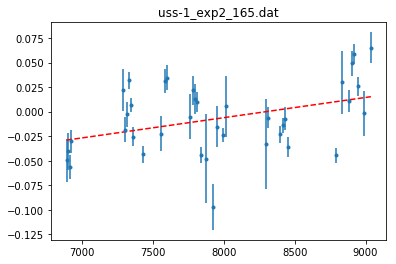

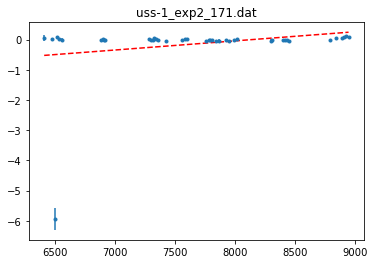

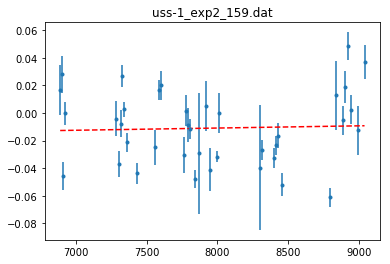

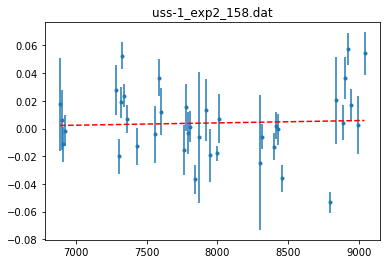

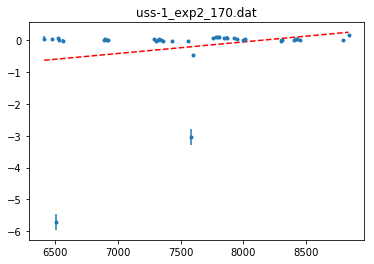

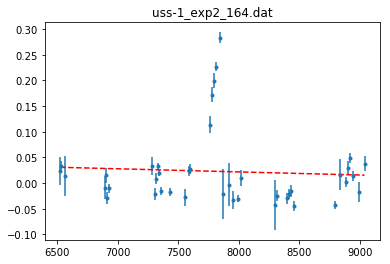

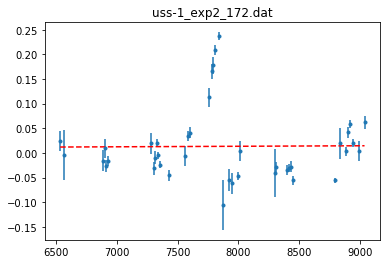

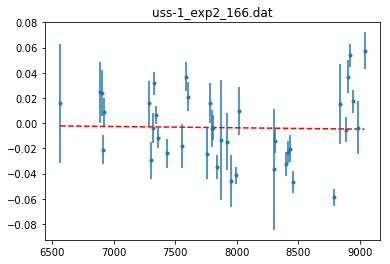

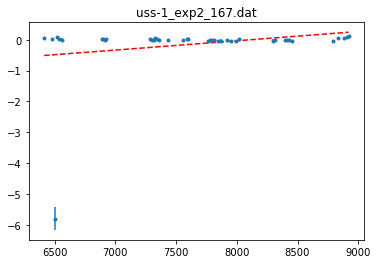

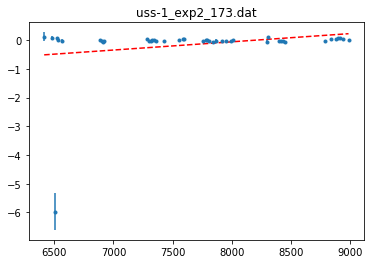

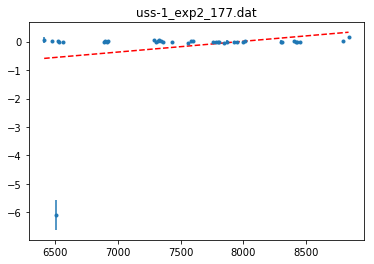

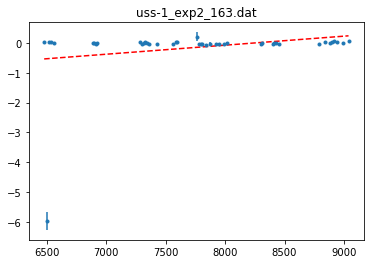

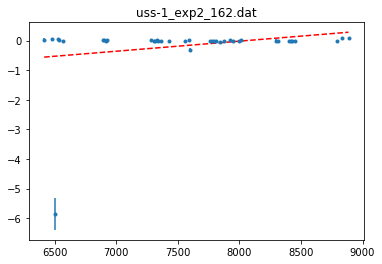

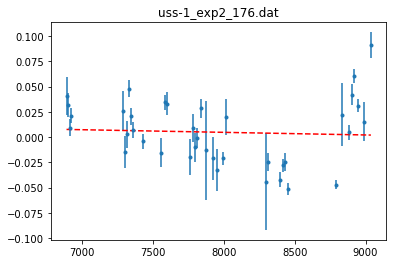

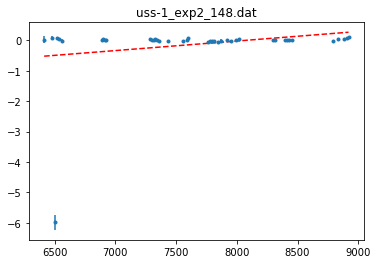

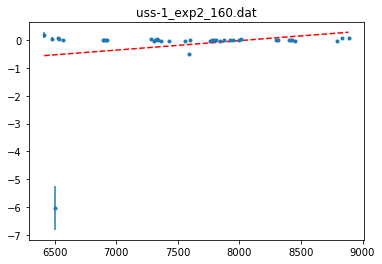

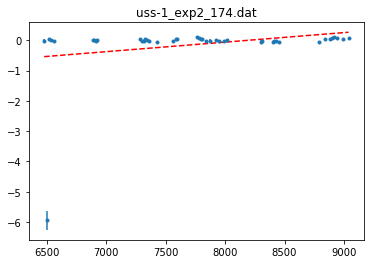

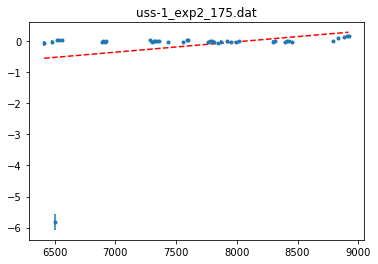

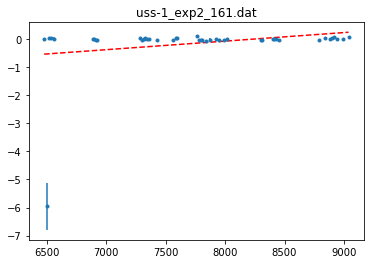

/Users/tac1998/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt


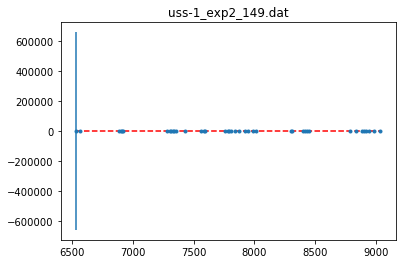

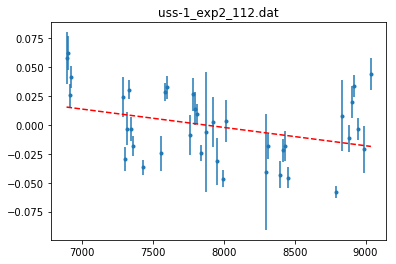

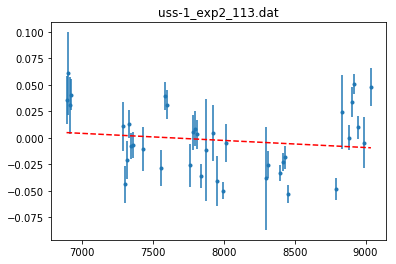

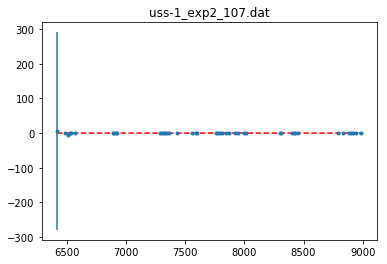

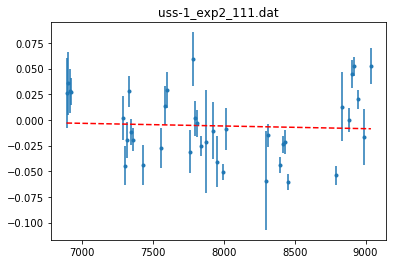

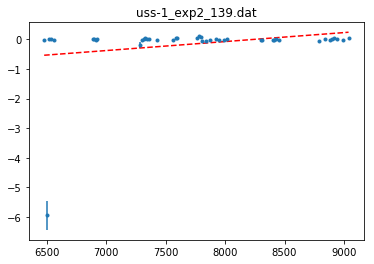

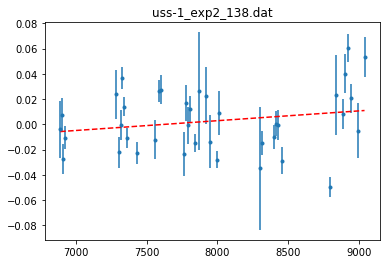

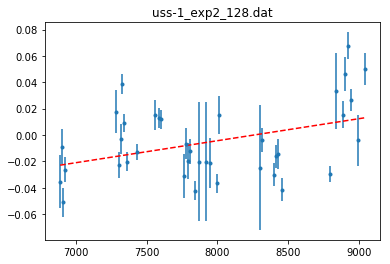

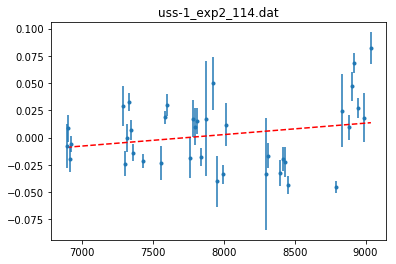

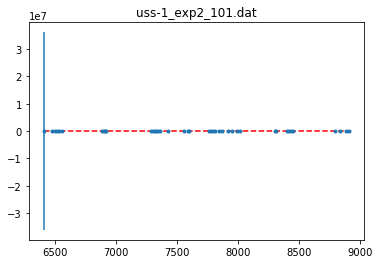

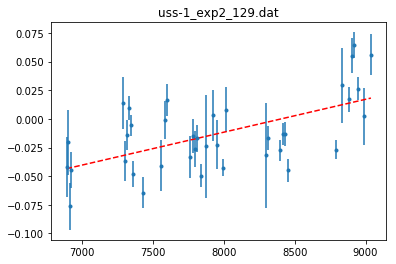

/Users/tac1998/anaconda/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


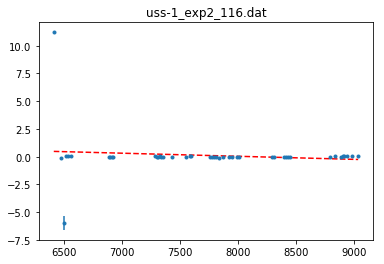

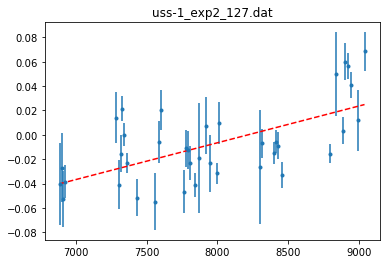

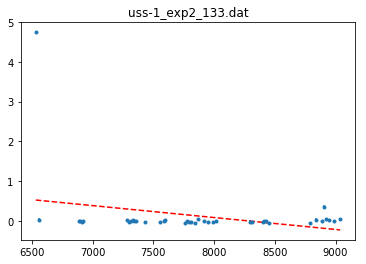

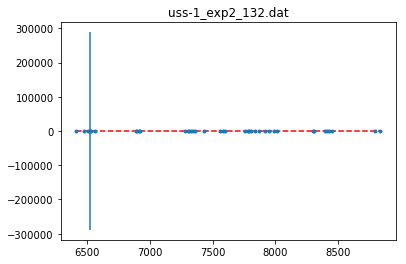

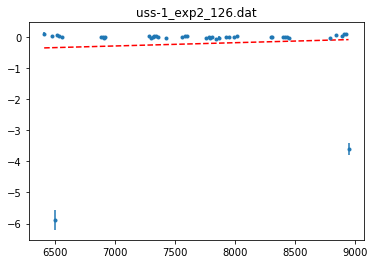

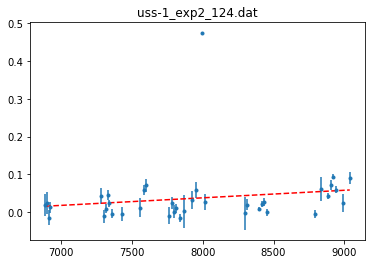

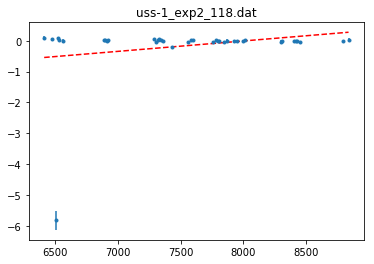

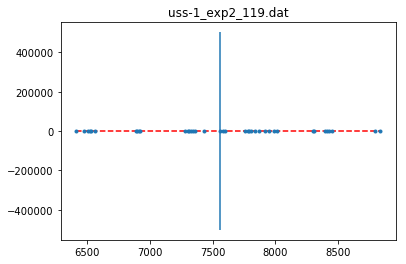

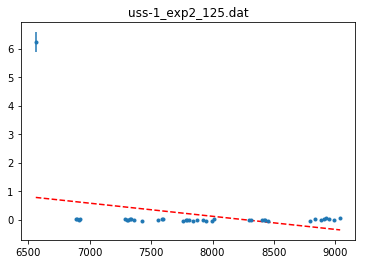

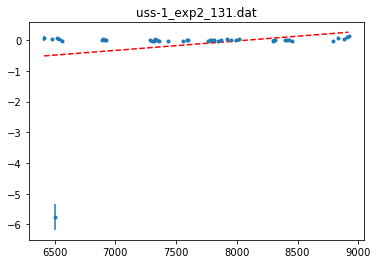

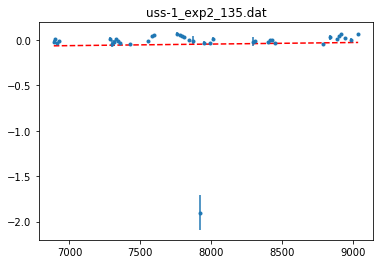

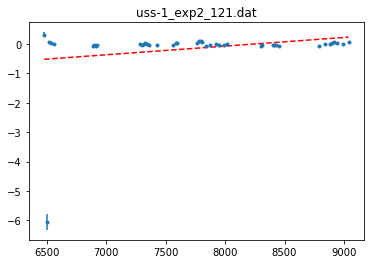

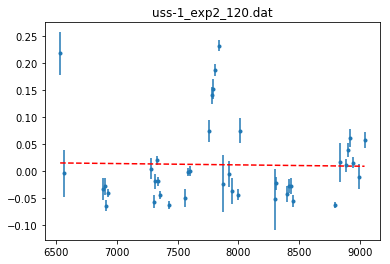

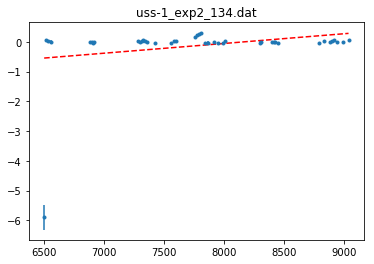

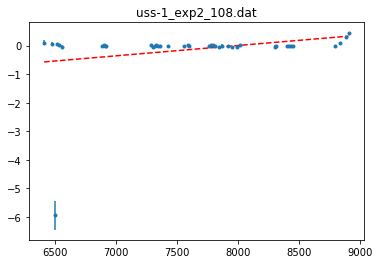

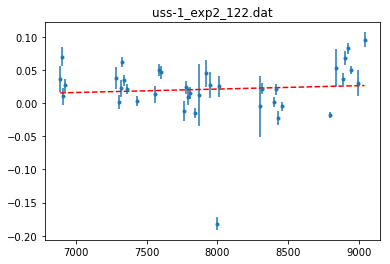

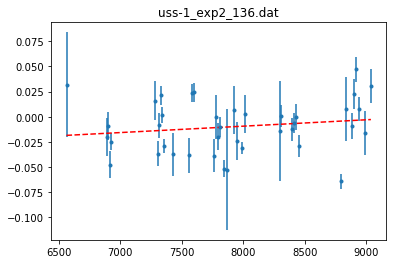

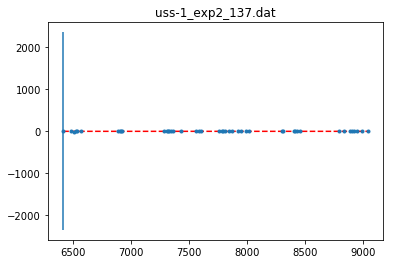

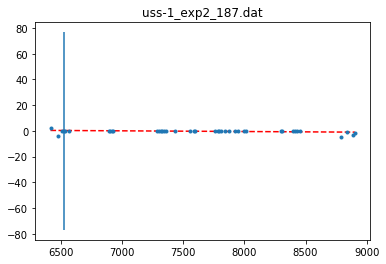

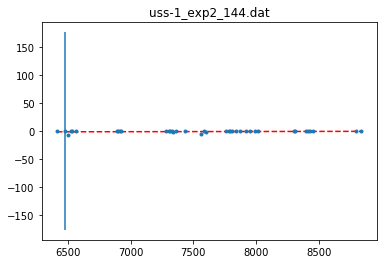

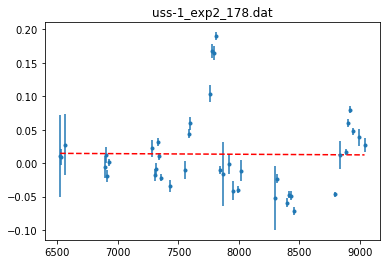

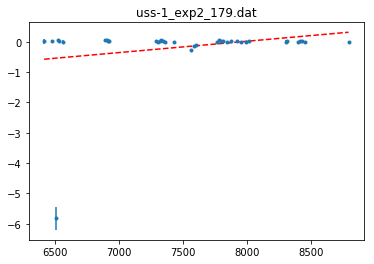

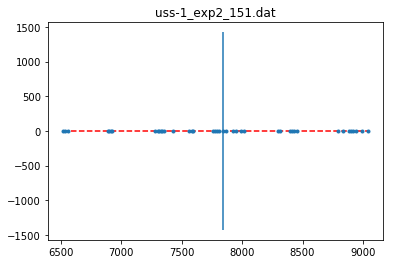

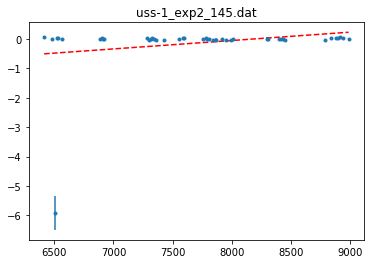

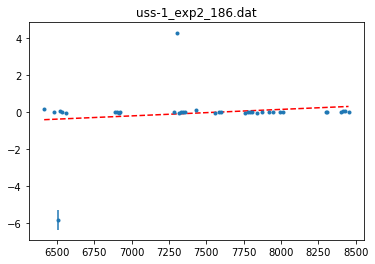

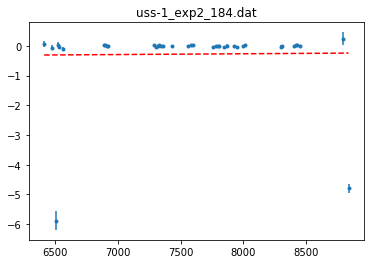

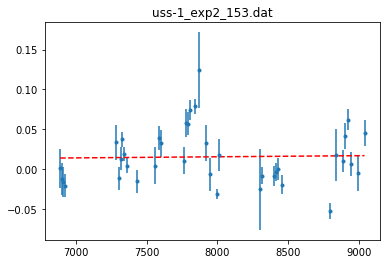

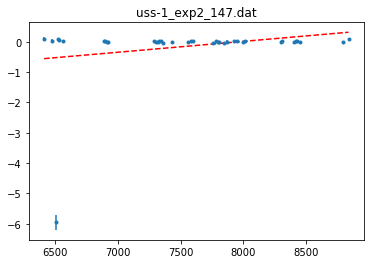

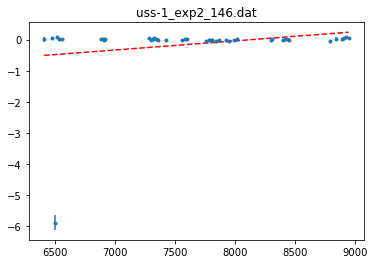

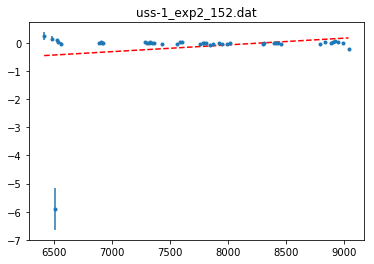

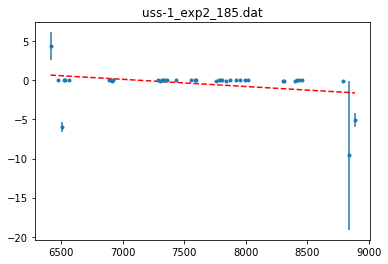

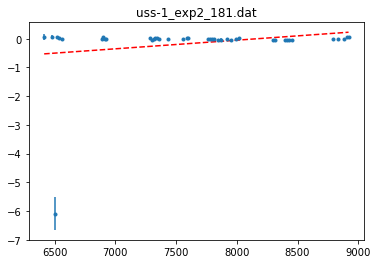

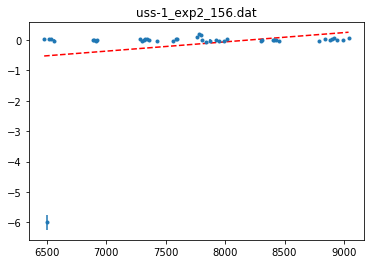

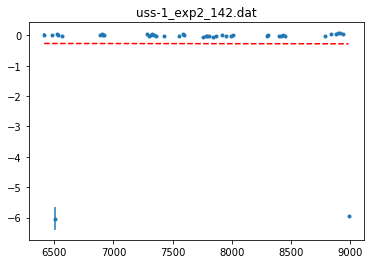

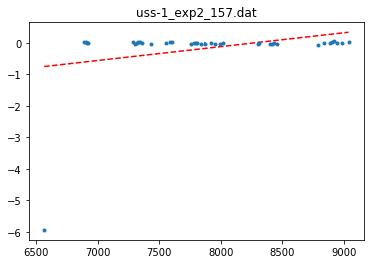

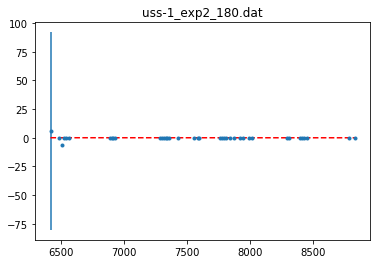

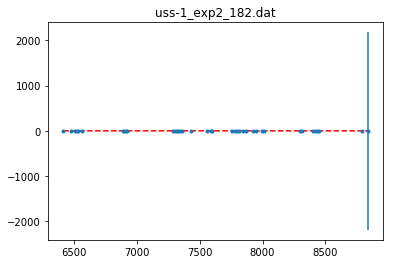

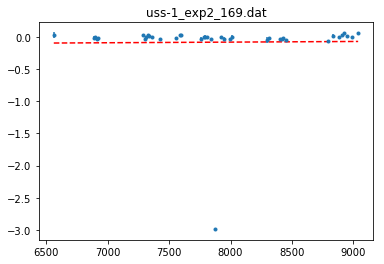

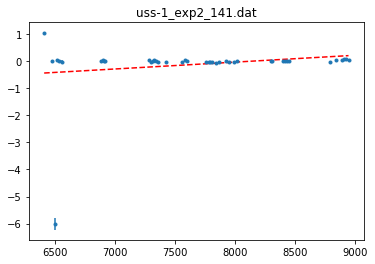

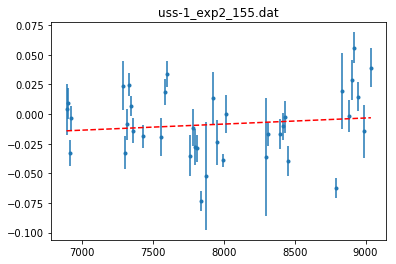

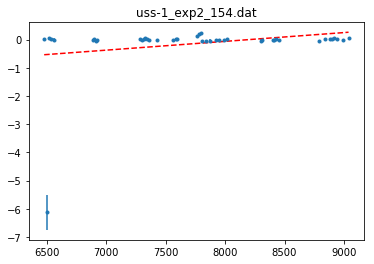

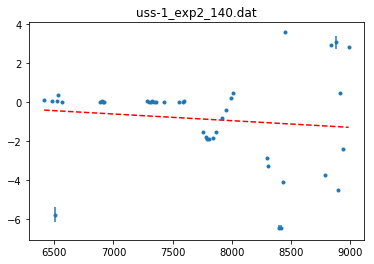

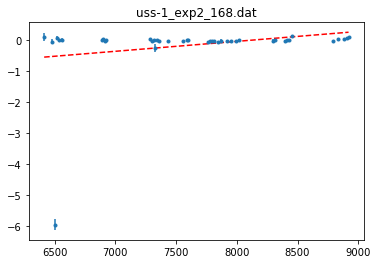

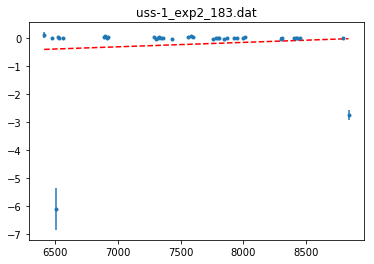

In [6]:
bad_slits_center = []

for f in files_2:
    
    line_centers = []
    line_center_err = []

    use_waves = []

    for w in wavel:

        one_file = pd.read_csv(f, sep='\s+')
        
        fname = str(f)
        slit_name = fname[-18:]
        
        ivar = one_file['IVAR']
        one_file['VAR'] = np.sqrt(1/(ivar))

        sline = w
        plus = sline + 6
        minus = sline - 6

        msk_10A = one_file['WAVE'].between(minus, plus, inclusive=True)
        gauss_range = one_file[msk_10A]
        gauss_range['WAVE'] -= sline

        if gauss_range.empty:
            pass

        else:
            try:
                waves = list(gauss_range['WAVE'])
                sky = list(gauss_range['SKY'])
                var = list(gauss_range['VAR'])

                std = gauss_range['SKY'].std()
                mean = gauss_range['SKY'].mean()
                mx = np.max(sky)

                guesses = gauss_guess(waves, sky)

                popt, pcov = curve_fit(gaussian, waves, sky, guesses, sigma=var)
                
            except (RuntimeError, TypeError):
                bad_slits_center.append(slit_name)
                    
            param_err = np.sqrt(np.diag(pcov))

            use_waves.append(w)

            center = popt[2]
            center_err = param_err[2]

            line_centers.append(center)
            line_center_err.append(center_err)
            
        
    plt.errorbar(use_waves,line_centers, yerr=line_center_err, fmt='.')
    
    fit = np.polyfit(use_waves,line_centers,1)
    fit_fn = np.poly1d(fit) 
    plt.plot(use_waves, fit_fn(use_waves), '--r')
    
    plt.title(slit_name)
    plt.show()

In [6]:
bad_slits_width = []
slit_kernel_means = []

for f in files_2:
    
    kernel = []
    kernel_err = []

    use_waves = []

    for w in wavel:

        one_file = pd.read_csv(f, sep='\s+')
        
        fname = str(f)
        slit_name = fname[-18:]
        
        ivar = one_file['IVAR']
        one_file['VAR'] = np.sqrt(1/(ivar))

        sline = w
        plus = sline + 6
        minus = sline - 6

        msk_10A = one_file['WAVE'].between(minus, plus, inclusive=True)
        gauss_range = one_file[msk_10A]
        gauss_range['WAVE'] -= sline

        if gauss_range.empty:
            pass

        else:
            try:
                waves = list(gauss_range['WAVE'])
                sky = list(gauss_range['SKY'])
                var = list(gauss_range['VAR'])

                std = gauss_range['SKY'].std()
                mean = gauss_range['SKY'].mean()
                mx = np.max(sky)

                guesses = gauss_guess(waves, sky)

                popt, pcov = curve_fit(gaussian, waves, sky, guesses, sigma=var)
                
            except (RuntimeError, TypeError):
                bad_slits_width.append(slit_name)
                    
            param_err = np.sqrt(np.diag(pcov))

            use_waves.append(w)

            width = popt[3]
            width_err = param_err[3]

            kernel.append(width)
            kernel_err.append(width_err)
            
    slit_kernel_means.append(np.mean(kernel))  
#     plt.errorbar(use_waves,kernel, yerr=kernel_err, fmt='.')
#     plt.axhline(np.mean(kernel), ls='--', c='red')
    
#     plt.title(slit_name)
#     plt.show()

/Users/tac1998/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/tac1998/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in sqrt
/Users/tac1998/anaconda/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [7]:
np.median(slit_kernel_means)

0.4817626347203523